## ChEMBL - Fetch Raw Data - P. falciparum (only WildType)

**Date:** 23/01/23

**Based on:** [TeachOpenCADD T001 - Compound data acquisition (ChEMBL)](https://projects.volkamerlab.org/teachopencadd/talktorials/T001_query_chembl.html)

**Done by:** Gustavo H. M. Sousa

Session information at the end of the notebook.

### Retrieving ChEMBL biological data of the target (DHFR) - Plasmodium

#### Importing, defining paths and specifying query parameters

First, we need to import the libraries we're going to use. It is best practice to first import them all and them proceed to further analysis.

In [1]:
import math
from pathlib import Path
from zipfile import ZipFile
from tempfile import TemporaryDirectory

import numpy as np
import pandas as pd
from rdkit.Chem import PandasTools
from chembl_webresource_client.new_client import new_client # This is the API chembl library
from tqdm.auto import tqdm

We can also use the `Path` package to define our relative or absolute directory path to save our files.

In [2]:
HERE = Path(_dh[-1])
DATA = HERE/"data"

Next, we can specify the parameters of our API data:

In [3]:
targets_api = new_client.target
compounds_api = new_client.molecule
bioactivities_api = new_client.activity

type(targets_api)

chembl_webresource_client.query_set.QuerySet

### Target Information

We can now specify the UniProt ID of our target, in our case we're going to start with the following:
* **UniProt ID:** P13922
* **Entry name:** DRTS_PLAFK
* **Organism:** *Plasmodium falciparum* (isolate K1 / Thailand)
* **Length:** 608 AA


In [4]:
uniprot_id = "P13922"

Then, we **fetch** the data for this UniProt ID.

In [5]:
targets = targets_api.get(target_components__accession=uniprot_id).only(
    "target_chembl_id", "organism", "pref_name", "target_type"
)

# We make sure that the 'targets' object is a chembl query by printing its type
print(type(targets))

<class 'chembl_webresource_client.query_set.QuerySet'>


As seen previously in other notebooks, the results of the query are store in `targets`a object of the type `QuerySet` and the results are not fetch from ChEMBL until we ask for it using the function `pd.DataFrame.from_records`. These type of `QuerySet` are called *lazy* for this reason. 

In [6]:
targets = pd.DataFrame.from_records(targets)
targets

,organism,pref_name,target_chembl_id,target_type
0,Plasmodium falciparum K1,Dihydrofolate reductase,CHEMBL1939,SINGLE PROTEIN
1,Plasmodium falciparum K1,Dihydrofolate reductase,CHEMBL1939,SINGLE PROTEIN


After inspecting our dataframe with the *'organism'*, *'pref_name'*, *'target_chembl_id'* and *'target_type'* we can select what row are of interest. In our case, the rows are both the same (I don't know exactly why) so we can select either. 

In [7]:
# We then fetch only the first row of our 'targets' dataframe object

targets = targets.iloc[0]
targets

organism            Plasmodium falciparum K1
pref_name            Dihydrofolate reductase
target_chembl_id                  CHEMBL1939
target_type                   SINGLE PROTEIN
Name: 0, dtype: object

Saving the *target_chembl_id* variable because this is going to come in hand later to fetch the biological data of our target.

In [8]:
chembl_id = targets.target_chembl_id
print(chembl_id)

CHEMBL1939


### Fetching biological data to our target

Now we can fetch the biological data for our target, taking the following into consideration:
* bioactivity type = `Ki`
* exact mesaruements (relation `=`)
* binding data (assay type `B`)

In [9]:
bioactivities_plasmodium = bioactivities_api.filter(
    target_chembl_id=chembl_id, type='Ki', relation='=',
    assay_type='B'
).only(
    'activity_id',
    'assay_chembl_id',
    'assay_description',
    'assay_type',
    'molecule_chembl_id',
    'type',
    'standard_units',
    'relation',
    'standard_units',
    'relation',
    'standard_value',
    'target_chembl_id',
    'target_organism'
)

print(f"The total size of the biological activities fetched is:{len(bioactivities_plasmodium)} of type, {type(bioactivities_plasmodium)}")

The total size of the biological activities fetched is:716 of type, <class 'chembl_webresource_client.query_set.QuerySet'>


Each element of our `bioactivities_plasmodium`objetc contains a dicionary:

In [10]:
print(f"{bioactivities_plasmodium[0]}")

{'activity_id': 185071, 'assay_chembl_id': 'CHEMBL811761', 'assay_description': 'Binding affinity was evaluated as inhibition of recombinant wild type (WT) Plasmodium falciparum DHFR-TS.', 'assay_type': 'B', 'molecule_chembl_id': 'CHEMBL2364573', 'relation': '=', 'standard_units': 'nM', 'standard_value': '4.7', 'target_chembl_id': 'CHEMBL1939', 'target_organism': 'Plasmodium falciparum K1', 'type': 'Ki', 'units': 'nM', 'value': '4.7'}


We can then download the *dataset* containing only `Ki` and exact measurements for our target:

In [11]:
bioactivities_plasmodium_df = pd.DataFrame.from_records(bioactivities_plasmodium)
print(f"The dataframe shape is: {bioactivities_plasmodium_df.shape}")

bioactivities_plasmodium_df.head(5)

The dataframe shape is: (717, 13)


,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,relation,standard_units,standard_value,target_chembl_id,target_organism,type,units,value
0,185071,CHEMBL811761,Binding affinity was evaluated as inhibition o...,B,CHEMBL2364573,=,nM,4.7,CHEMBL1939,Plasmodium falciparum K1,Ki,nM,4.7
1,185071,CHEMBL811761,Binding affinity was evaluated as inhibition o...,B,CHEMBL2364573,=,nM,4.7,CHEMBL1939,Plasmodium falciparum K1,Ki,nM,4.7
2,185072,CHEMBL811759,Binding affinity was evaluated as inhibition o...,B,CHEMBL2364573,=,nM,14.5,CHEMBL1939,Plasmodium falciparum K1,Ki,nM,14.5
3,187525,CHEMBL821379,Inhibitory activity against wild-type dihydrof...,B,CHEMBL324775,=,nM,3.1,CHEMBL1939,Plasmodium falciparum K1,Ki,nM,3.1
4,187527,CHEMBL668412,Inhibitory activity against double mutant dihy...,B,CHEMBL324775,=,nM,103.5,CHEMBL1939,Plasmodium falciparum K1,Ki,nM,103.5


We can do a first estimation of unique structures in our dataset. For the *P. falciparum* type K1 we have almost 150 strcutures. It is possible that after the processing of our data we end up with way less than this, but this is a decent estimation

In [12]:
# Estimation of unique values:
print(bioactivities_plasmodium_df['molecule_chembl_id'].unique().shape[0])

145


In [13]:
bioactivities_plasmodium_df['units'].unique()

array(['nM', 'uM'], dtype=object)

Note also that we have columns for `standard_units/units`and `standard_values/values` so we don't need the `units` and `values` variables. We will thus, drop the other two columns.

In [14]:
bioactivities_plasmodium_df.drop(['units', 'value'], axis=1, inplace=True)
bioactivities_plasmodium_df.head(5)

,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,relation,standard_units,standard_value,target_chembl_id,target_organism,type
0,185071,CHEMBL811761,Binding affinity was evaluated as inhibition o...,B,CHEMBL2364573,=,nM,4.7,CHEMBL1939,Plasmodium falciparum K1,Ki
1,185071,CHEMBL811761,Binding affinity was evaluated as inhibition o...,B,CHEMBL2364573,=,nM,4.7,CHEMBL1939,Plasmodium falciparum K1,Ki
2,185072,CHEMBL811759,Binding affinity was evaluated as inhibition o...,B,CHEMBL2364573,=,nM,14.5,CHEMBL1939,Plasmodium falciparum K1,Ki
3,187525,CHEMBL821379,Inhibitory activity against wild-type dihydrof...,B,CHEMBL324775,=,nM,3.1,CHEMBL1939,Plasmodium falciparum K1,Ki
4,187527,CHEMBL668412,Inhibitory activity against double mutant dihy...,B,CHEMBL324775,=,nM,103.5,CHEMBL1939,Plasmodium falciparum K1,Ki


### Preprocess the data

For the pre-processing procedure of the data we're going to do the following:
1. Convert the `standard_value` type from object to `float64`
2. Delete entries with missing values
3. Keep only nanomolar activities
4. Delete duplicate molecules
5. Reset the df index
6. Rename columns


#### 1. Convert `standard_value` type

In [15]:
bioactivities_plasmodium_df = bioactivities_plasmodium_df.astype({'standard_value':'float64'})
bioactivities_plasmodium_df.dtypes

activity_id             int64
assay_chembl_id        object
assay_description      object
assay_type             object
molecule_chembl_id     object
relation               object
standard_units         object
standard_value        float64
target_chembl_id       object
target_organism        object
type                   object
dtype: object

#### 2. Delete entries with missing values

In [16]:
bioactivities_plasmodium_df.dropna(axis=0, how='any', inplace=True)
print(f"The shape after dropping NA values: {bioactivities_plasmodium_df.shape}")

The shape after dropping NA values: (717, 11)


#### 3. Keep only entries with "standard_unit == nM"

In [17]:
print(f"{bioactivities_plasmodium_df['standard_units'].unique()}")

print(f"Number of non-Nm entries: {bioactivities_plasmodium_df[bioactivities_plasmodium_df['standard_units'] != 'nM'].shape[0]}")

['nM']
Number of non-Nm entries: 0


#### 4. Delete or group by mean diplicated molecuels

Sometimes the same molecule, i.e. same *molecule_chembl_id* has been tested more than once, in this case, we only keep the first one or even keep the mean of the measurements. We're going to keep only the 'Wild-type' measurements in this case.

In [18]:
only_wildtype = bioactivities_plasmodium_df[~bioactivities_plasmodium_df['assay_description'].str.contains('utant', regex=False, case=False)].reset_index(drop=True)
print(f"Shape of only_wildtype dataset {only_wildtype.shape[0]}")
only_wildtype.head(3)

Shape of only_wildtype dataset 305


,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,relation,standard_units,standard_value,target_chembl_id,target_organism,type
0,185071,CHEMBL811761,Binding affinity was evaluated as inhibition o...,B,CHEMBL2364573,=,nM,4.7,CHEMBL1939,Plasmodium falciparum K1,Ki
1,185071,CHEMBL811761,Binding affinity was evaluated as inhibition o...,B,CHEMBL2364573,=,nM,4.7,CHEMBL1939,Plasmodium falciparum K1,Ki
2,187525,CHEMBL821379,Inhibitory activity against wild-type dihydrof...,B,CHEMBL324775,=,nM,3.1,CHEMBL1939,Plasmodium falciparum K1,Ki


We have approximately 305 observations for the wild-type but most of them is repeated measurments or duplicated entries. We're going to group them by the mean and set this dataset apart.

In [19]:
# Standard_value already as float so we can skip the part when we convert it
only_wildtype_mean = only_wildtype[['molecule_chembl_id','standard_value']].groupby('molecule_chembl_id').mean().reset_index()

# Renaming the variables
only_wildtype_mean.rename(columns={'standard_value':'mean_standard_value'}, inplace=True)

print(f"By keeping the mean and merging duplicated entries we're left with: {only_wildtype_mean.shape[0]} entries")
only_wildtype_mean.head(5)

By keeping the mean and merging duplicated entries we're left with: 145 entries


,molecule_chembl_id,mean_standard_value
0,CHEMBL115483,2.0
1,CHEMBL118202,2.3
2,CHEMBL118425,7.0
3,CHEMBL118581,2.5
4,CHEMBL118602,3.5


Next, we drop the duplicates of the `only_wildtype` dataframe employing the `drop_duplicates` of pandas package.

In [20]:
# Dropping the duplicates 
only_wildtype_first = only_wildtype.drop_duplicates('molecule_chembl_id', keep='first')

# Renaming the columns. I was using the inplace=True argument but resulted in warning
only_wildtype_first = only_wildtype_first.rename(columns={'standard_value':'first_standard_value'})

# Reseting the index
only_wildtype_first = only_wildtype_first.reset_index(drop=True)
only_wildtype_first.head(5)

,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,relation,standard_units,first_standard_value,target_chembl_id,target_organism,type
0,185071,CHEMBL811761,Binding affinity was evaluated as inhibition o...,B,CHEMBL2364573,=,nM,4.7,CHEMBL1939,Plasmodium falciparum K1,Ki
1,187525,CHEMBL821379,Inhibitory activity against wild-type dihydrof...,B,CHEMBL324775,=,nM,3.1,CHEMBL1939,Plasmodium falciparum K1,Ki
2,188709,CHEMBL821379,Inhibitory activity against wild-type dihydrof...,B,CHEMBL416373,=,nM,0.4,CHEMBL1939,Plasmodium falciparum K1,Ki
3,189896,CHEMBL821379,Inhibitory activity against wild-type dihydrof...,B,CHEMBL291931,=,nM,7.2,CHEMBL1939,Plasmodium falciparum K1,Ki
4,189912,CHEMBL821379,Inhibitory activity against wild-type dihydrof...,B,CHEMBL119188,=,nM,0.6,CHEMBL1939,Plasmodium falciparum K1,Ki


Finally, we merge both datasets so we can keep both informations: the mean and the first appearance of the measurement.

In [21]:
merged_only_wt = pd.merge(only_wildtype_first, only_wildtype_mean, how='left', on='molecule_chembl_id')
merged_only_wt.head(5)

,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,relation,standard_units,first_standard_value,target_chembl_id,target_organism,type,mean_standard_value
0,185071,CHEMBL811761,Binding affinity was evaluated as inhibition o...,B,CHEMBL2364573,=,nM,4.7,CHEMBL1939,Plasmodium falciparum K1,Ki,4.7
1,187525,CHEMBL821379,Inhibitory activity against wild-type dihydrof...,B,CHEMBL324775,=,nM,3.1,CHEMBL1939,Plasmodium falciparum K1,Ki,3.1
2,188709,CHEMBL821379,Inhibitory activity against wild-type dihydrof...,B,CHEMBL416373,=,nM,0.4,CHEMBL1939,Plasmodium falciparum K1,Ki,0.4
3,189896,CHEMBL821379,Inhibitory activity against wild-type dihydrof...,B,CHEMBL291931,=,nM,7.2,CHEMBL1939,Plasmodium falciparum K1,Ki,7.2
4,189912,CHEMBL821379,Inhibitory activity against wild-type dihydrof...,B,CHEMBL119188,=,nM,0.6,CHEMBL1939,Plasmodium falciparum K1,Ki,0.6


#### 5. Reseting the DF Index

In [22]:
merged_only_wt.reset_index(inplace=True, drop=True)
merged_only_wt.head(3)

,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,relation,standard_units,first_standard_value,target_chembl_id,target_organism,type,mean_standard_value
0,185071,CHEMBL811761,Binding affinity was evaluated as inhibition o...,B,CHEMBL2364573,=,nM,4.7,CHEMBL1939,Plasmodium falciparum K1,Ki,4.7
1,187525,CHEMBL821379,Inhibitory activity against wild-type dihydrof...,B,CHEMBL324775,=,nM,3.1,CHEMBL1939,Plasmodium falciparum K1,Ki,3.1
2,188709,CHEMBL821379,Inhibitory activity against wild-type dihydrof...,B,CHEMBL416373,=,nM,0.4,CHEMBL1939,Plasmodium falciparum K1,Ki,0.4


#### 6. Renaming and reordering the columns

In [24]:
# We already renamed the columns so we only need to redordem them.

merged_only_wt = merged_only_wt[['activity_id', 'assay_chembl_id', 'assay_description', 'assay_type', 'molecule_chembl_id', 'relation', 'first_standard_value', 'mean_standard_value', 'standard_units', 'target_chembl_id', 'target_organism']]
merged_only_wt.head(3)

,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,relation,first_standard_value,mean_standard_value,standard_units,target_chembl_id,target_organism
0,185071,CHEMBL811761,Binding affinity was evaluated as inhibition o...,B,CHEMBL2364573,=,4.7,4.7,nM,CHEMBL1939,Plasmodium falciparum K1
1,187525,CHEMBL821379,Inhibitory activity against wild-type dihydrof...,B,CHEMBL324775,=,3.1,3.1,nM,CHEMBL1939,Plasmodium falciparum K1
2,188709,CHEMBL821379,Inhibitory activity against wild-type dihydrof...,B,CHEMBL416373,=,0.4,0.4,nM,CHEMBL1939,Plasmodium falciparum K1


### Download the compound data from ChEMBL

Finally download the compound data from the ChEMBL database, again using hte API from the site:

In [25]:
compounds_provider = compounds_api.filter(
    molecule_chembl_id__in=list(merged_only_wt['molecule_chembl_id'])
).only('molecule_chembl_id', 'molecule_structures')

compounds = list(tqdm(compounds_provider))

  0%|          | 0/145 [00:00<?, ?it/s]

After wating for the compounds to be fetched, we can see the SMILES gathered:

In [26]:
compounds_df = pd.DataFrame.from_records(compounds)
print(compounds_df.shape)
compounds_df.head(5)

(145, 2)


,molecule_chembl_id,molecule_structures
0,CHEMBL7004,{'canonical_smiles': 'Cc1ccc(N2C(N)=NC(N)=NC2(...
1,CHEMBL7005,{'canonical_smiles': 'CC1(C)N=C(N)N=C(N)N1c1cc...
2,CHEMBL6741,{'canonical_smiles': 'CC1(C)N=C(N)N=C(N)N1c1cc...
3,CHEMBL6742,{'canonical_smiles': 'CC1(C)N=C(N)N=C(N)N1c1cc...
4,CHEMBL22,{'canonical_smiles': 'COc1cc(Cc2cnc(N)nc2N)cc(...


We have to perform the following steps:

1. Remove the entries with missing structures
2. Delete duplicate molecule by `molecule_chembl_id` variable
3. Get only molecules with **Canonical SMILES**

#### 1. Removing missing structures

In [27]:
compounds_df.dropna(axis=0, how='any', inplace=True)
print(compounds_df.shape[0])

145


#### 2. Delete duplicates

In [28]:
compounds_df.drop_duplicates('molecule_chembl_id', keep = 'first', inplace = True)
print(compounds_df.shape[0])

145


#### 3. Only Canonical SMILES

As one can see, we have multiple outputs for the structure gathered in `compounds_df`, but we only want to keep the canonical_smiles information.

In [29]:
compounds_df.iloc[0].molecule_structures.keys()

dict_keys(['canonical_smiles', 'molfile', 'standard_inchi', 'standard_inchi_key'])

We can do a `for` loop to retrieve only the canonical_smiles key. That's what we do below:

In [32]:
canonical_smiles = []

for i, compounds in compounds_df.iterrows():
    try:
        canonical_smiles.append(compounds['molecule_structures']['canonical_smiles'])

    except KeyError:
        canonical_smiles.append(None)

compounds_df['smiles'] = canonical_smiles
compounds_df.drop('molecule_structures', axis=1, inplace=True)

**Sanity check:** to see if there is any NA value appeded before

In [33]:
compounds_df.dropna(axis=0, how='any', inplace=True)
print(f"The shape of the compounds dataset is: {compounds_df.shape}")
compounds_df.head(3)

The shape of the compounds dataset is: (145, 2)


,molecule_chembl_id,smiles
0,CHEMBL7004,Cc1ccc(N2C(N)=NC(N)=NC2(C)C)cc1
1,CHEMBL7005,CC1(C)N=C(N)N=C(N)N1c1ccc(F)cc1
2,CHEMBL6741,CC1(C)N=C(N)N=C(N)N1c1ccc(Br)cc1


### Output of the data

Doing a summary of the data that we have gathered so far, that is: the `merged_only_wt` and the `compounds_df`. The first one contains the biological activities and the second one contains the smiles respective to each `molecule_chembl_id`.

In [34]:
print(f"Total molecule_ids retrieved from ChEMBL for our plasmodium target: {merged_only_wt.shape[0]}\n")
merged_only_wt.columns

Total molecule_ids retrieved from ChEMBL for our plasmodium target: 145



Index(['activity_id', 'assay_chembl_id', 'assay_description', 'assay_type',
       'molecule_chembl_id', 'relation', 'first_standard_value',
       'mean_standard_value', 'standard_units', 'target_chembl_id',
       'target_organism'],
      dtype='object')

For instance, the `canonical_smiles` fetched, we have:

In [35]:
print(f"Total canonical_smiles fetched for our plasmodium target: {compounds_df.shape[0]}\n")

compounds_df.columns

Total canonical_smiles fetched for our plasmodium target: 145



Index(['molecule_chembl_id', 'smiles'], dtype='object')

### Merge both datasets

Merging both datasets so we can do a `csv` of our outputs and get a preprocessed data to pipe into the cleaning process. We're basically going to merge the datasets and keep the following columns:

* ChEMBL IDs: `molecule_chembl_id`
* SMILES: `smiles`
* Units: `standard_units`
* First Ki: `first_standard_value`
* Mean Ki: `mean_standard_value`
* Standard Units: `standard_units`
* Target: `target_organism`

In [36]:
# Merging both datasets
only_wt_chembl_df = pd.merge(
    merged_only_wt[['molecule_chembl_id', 'first_standard_value', 'mean_standard_value', 'standard_units', 'target_organism']],
    compounds_df,
    on='molecule_chembl_id'
)

only_wt_chembl_df.head(5)

,molecule_chembl_id,first_standard_value,mean_standard_value,standard_units,target_organism,smiles
0,CHEMBL2364573,4.7,4.7,nM,Plasmodium falciparum K1,NC(=O)c1ccc[n+]([C@H]2O[C@@H](COP(=O)([O-])OP(...
1,CHEMBL324775,3.1,3.1,nM,Plasmodium falciparum K1,CCCCCCCOc1cc(Cc2cnc(N)nc2N)ccc1OC
2,CHEMBL416373,0.4,0.4,nM,Plasmodium falciparum K1,CCCCOc1cc(Cc2cnc(N)nc2N)ccc1OCc1cc(OC)c(OC)c(O...
3,CHEMBL291931,7.2,7.2,nM,Plasmodium falciparum K1,COc1ccc(Cc2cnc(N)nc2N)cc1OCc1ccccc1
4,CHEMBL119188,0.6,0.6,nM,Plasmodium falciparum K1,CCOc1cc(Cc2cnc(N)nc2N)ccc1OCCCOc1ccccc1


### Add pKi values

It is widely known to the QSAR community that, converting raw Ki numbers to pKi is an important step into the modeling pipeline. Because of that, we need to transform our previously collect Ki values into pKi values. First we make a function to convert pKi to Ki `convert_pki` and use the `apply` method in the vertical axis=1.

In [37]:
# Define a function that convert the Ki to pKi
def convert_pki(Ki):
    pKi_value = 9 - math.log10(Ki)
    return pKi_value

In [38]:
only_wt_chembl_df['pKi_mean_value'] = only_wt_chembl_df.apply(lambda x: convert_pki(x.mean_standard_value), axis=1)

only_wt_chembl_df['pKi_first_value'] = only_wt_chembl_df.apply(lambda x: convert_pki(x.first_standard_value), axis=1)

only_wt_chembl_df.head(5)

,molecule_chembl_id,first_standard_value,mean_standard_value,standard_units,target_organism,smiles,pKi_mean_value,pKi_first_value
0,CHEMBL2364573,4.7,4.7,nM,Plasmodium falciparum K1,NC(=O)c1ccc[n+]([C@H]2O[C@@H](COP(=O)([O-])OP(...,8.327902,8.327902
1,CHEMBL324775,3.1,3.1,nM,Plasmodium falciparum K1,CCCCCCCOc1cc(Cc2cnc(N)nc2N)ccc1OC,8.508638,8.508638
2,CHEMBL416373,0.4,0.4,nM,Plasmodium falciparum K1,CCCCOc1cc(Cc2cnc(N)nc2N)ccc1OCc1cc(OC)c(OC)c(O...,9.397940,9.397940
3,CHEMBL291931,7.2,7.2,nM,Plasmodium falciparum K1,COc1ccc(Cc2cnc(N)nc2N)cc1OCc1ccccc1,8.142668,8.142668
4,CHEMBL119188,0.6,0.6,nM,Plasmodium falciparum K1,CCOc1cc(Cc2cnc(N)nc2N)ccc1OCCCOc1ccccc1,9.221849,9.221849


Our final dataset can be further curated and streamlined into the following process steps now, we just need to save it into an appropriate '.csv' file to be incorporated in further scripts.

### Drawing the distributions

array([[<AxesSubplot: title={'center': 'pKi_mean_value'}>]], dtype=object)

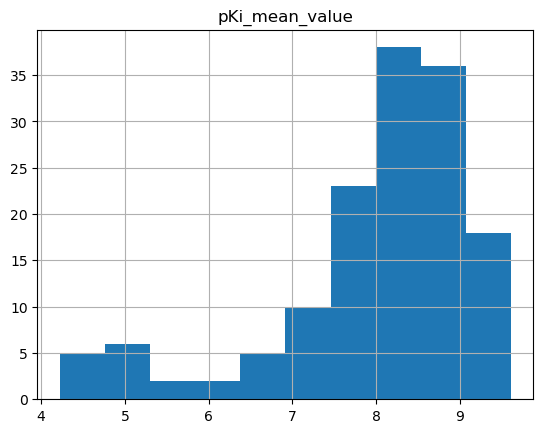

In [39]:
only_wt_chembl_df.hist(column='pKi_mean_value')

array([[<AxesSubplot: title={'center': 'pKi_first_value'}>]], dtype=object)

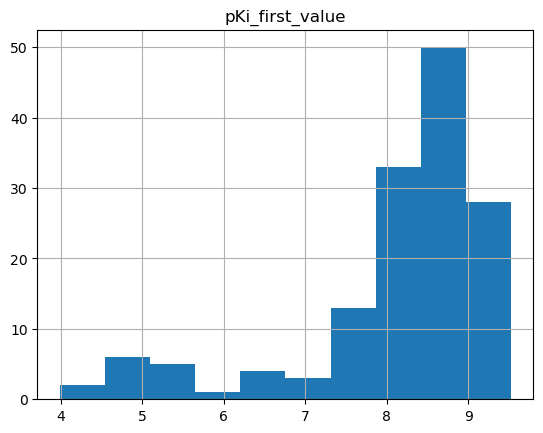

In [40]:
only_wt_chembl_df.hist(column='pKi_first_value')

### Saving the final output (csv)

We need to reorder the columns to save it as a `csv` file:

In [41]:
only_wt_chembl_df_final = only_wt_chembl_df[['molecule_chembl_id', 'smiles', 'pKi_mean_value' , 'mean_standard_value', 'pKi_first_value', 'first_standard_value', 'standard_units', 'target_organism']]

only_wt_chembl_df_final.head(5)

,molecule_chembl_id,smiles,pKi_mean_value,mean_standard_value,pKi_first_value,first_standard_value,standard_units,target_organism
0,CHEMBL2364573,NC(=O)c1ccc[n+]([C@H]2O[C@@H](COP(=O)([O-])OP(...,8.327902,4.7,8.327902,4.7,nM,Plasmodium falciparum K1
1,CHEMBL324775,CCCCCCCOc1cc(Cc2cnc(N)nc2N)ccc1OC,8.508638,3.1,8.508638,3.1,nM,Plasmodium falciparum K1
2,CHEMBL416373,CCCCOc1cc(Cc2cnc(N)nc2N)ccc1OCc1cc(OC)c(OC)c(O...,9.397940,0.4,9.397940,0.4,nM,Plasmodium falciparum K1
3,CHEMBL291931,COc1ccc(Cc2cnc(N)nc2N)cc1OCc1ccccc1,8.142668,7.2,8.142668,7.2,nM,Plasmodium falciparum K1
4,CHEMBL119188,CCOc1cc(Cc2cnc(N)nc2N)ccc1OCCCOc1ccccc1,9.221849,0.6,9.221849,0.6,nM,Plasmodium falciparum K1


In [42]:
only_wt_chembl_df_final.to_csv(DATA/'onlywt_plasmodium_dhfr_chembl_compounds.csv', index=False)

## Session and packages used on this notebook:

In [43]:
import session_info
session_info.show()